In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = '16'

### Import dependencies and filter out assumptions a DataReader class

In [2]:

class DataReader:
    def __init__(self):
        self.route_cols = ['ROUTE_NAME', 'SERVICE_DAY', 'OPERATIONAL_TRUCK_TYPE',
                           'Shape__Area', 'Shape__Length', 'mean_lat', 'mean_long']

    def load_data(self, path: str) -> pd.DataFrame:
        """
        Load data and reformat dates to relevant format.
        """
        data = pd.read_csv(path)
        data['Report Date'] = pd.to_datetime(
            data['Report Date'], format="%m/%d/%Y")
        data['Load Time'] = pd.to_datetime(
            data['Load Time'], format="%m/%d/%Y %I:%M:%S %p")
        return data

    @staticmethod
    def filter_assumptions(data: pd.DataFrame) -> pd.DataFrame:
        """
        Consider only the relevant subset of the dataset. based on our prior assumptions
        defined in the summary.
        """
        return data[(data['Route Type'] == 'GARBAGE COLLECTION') &
                    (data['Report Date'].dt.year.isin(list(range(2009, 2019, 1))))]

    def load_routes(self, path: str) -> pd.DataFrame:
        """
        Load information on the relevant routes and its geographical locations
        """
        def polygon_extractor(x):
            values = np.matrix(x[12:].replace(
                '(', '[').replace(')', ']').replace(',', ';'))
            return np.array(values.mean(axis=0))
        routes = pd.DataFrame()
        for route_file in os.listdir(path):
            route = pd.read_csv(Path('./data/routes/', route_file))
            mean_coords_df = route['the_geom'].apply(
                lambda x: polygon_extractor(x)[0])
            mean_cords_df = pd.DataFrame(mean_coords_df.tolist(), columns=[
                                         'mean_lat', 'mean_long'])
            # concat df and split_df
            route = pd.concat([route, mean_cords_df], axis=1)
            route = route.loc[:, np.isin(route.columns, self.route_cols)]
            routes = pd.concat([routes, route], axis=0)
        return routes

# Loading Data

In [3]:
reader = DataReader()
data = reader.load_data('./data/Waste_Collection___Diversion_Report__daily_.csv')

# Global crisis effect (2007-2009)

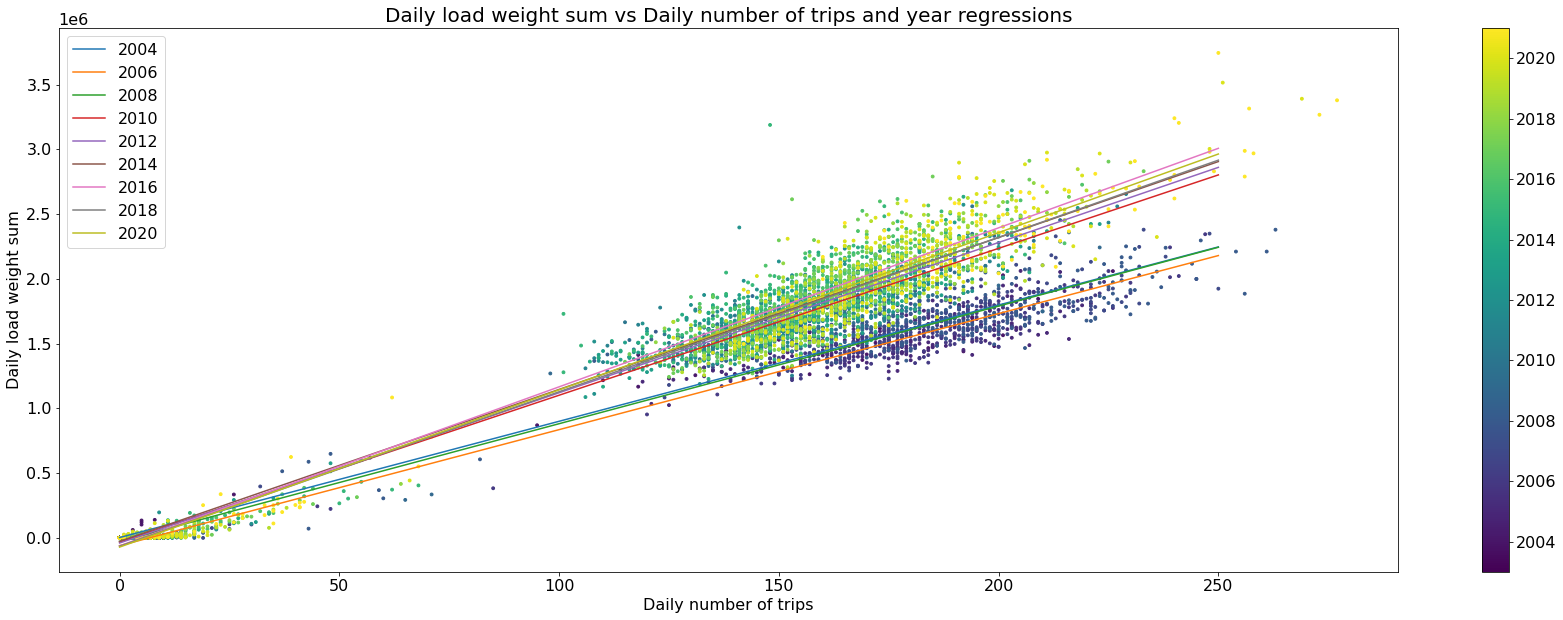

In [4]:
[fig,ax] = plt.subplots(nrows=1,ncols=1,figsize=(30,10))
# group by day: count trips and sum load weights
data_gb_day = data.groupby(pd.Grouper(key='Report Date', axis=0, freq='D')) \
    .agg({'Load ID':'count','Load Weight':'sum'}) \
    .reset_index()
# plot daily number of trips vs daily sum of load weights 
sct = ax.scatter(data_gb_day['Load ID'], \
    data_gb_day['Load Weight'], \
    c=data_gb_day['Report Date'].dt.year, \
    s = 8)
plt.colorbar(sct)
# regress daily number of trips vs daily sum of load weights to see trends
for i,year in enumerate(list(range(2004,2021,2))):
    lr = LinearRegression()
    fil = data_gb_day['Report Date'].dt.year == year
    x = data_gb_day.loc[fil,'Load ID']
    x = x[:, np.newaxis]
    y = data_gb_day.loc[fil,'Load Weight']
    lr.fit(x,y)
    plot_x = np.linspace(0,250,10)
    plot_y = lr.coef_[0]*plot_x + lr.intercept_
    ax.plot(plot_x,plot_y,label = year)
ax.set_title('Daily load weight sum vs Daily number of trips and year regressions', fontsize=20)
ax.set_ylabel('Daily load weight sum', fontsize=16)
ax.set_xlabel('Daily number of trips', fontsize=16)
ax.legend()

# Predominant route types

Text(0, 0.5, 'Relative Frequency')

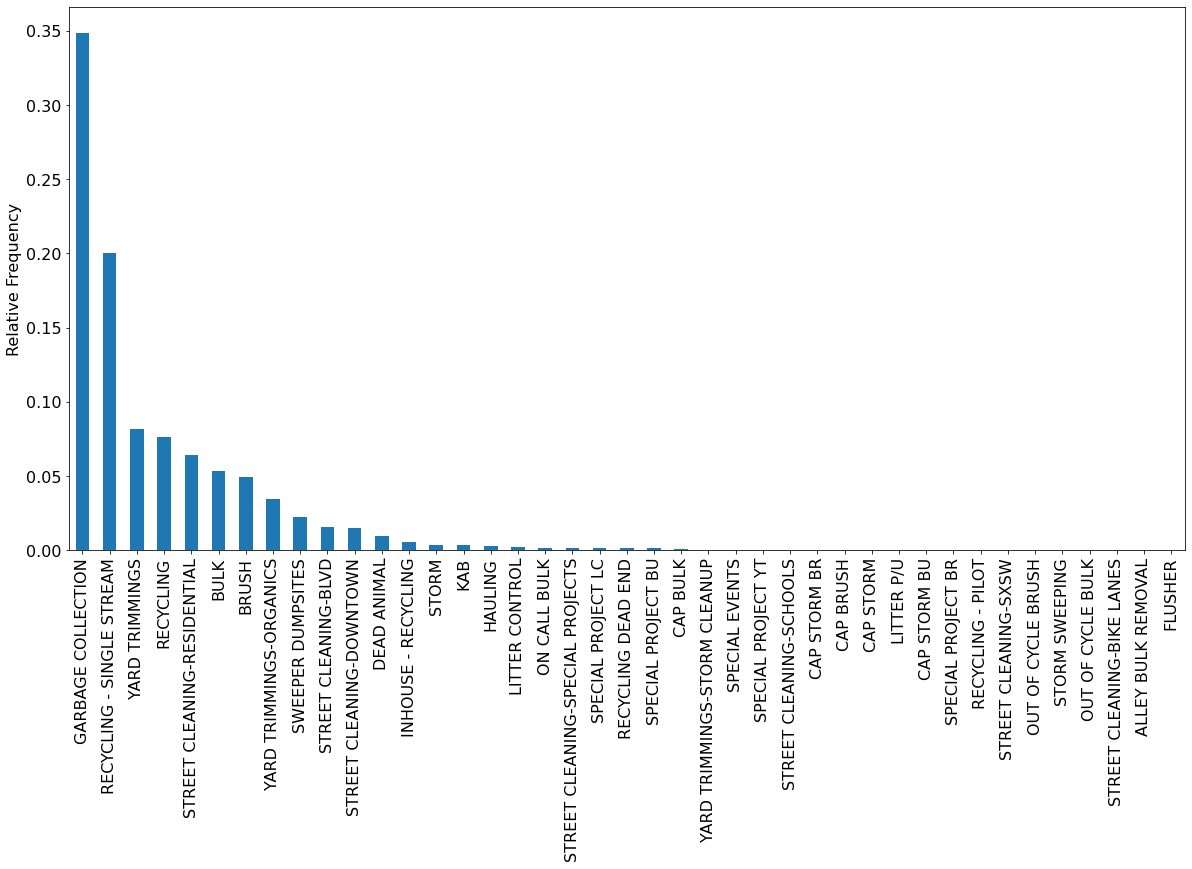

In [5]:
(data['Route Type'].value_counts() / data.shape[0]).plot.bar(figsize=(20,10))
plt.ylabel('Relative Frequency')

# Distribution of maximum load weights and outliers

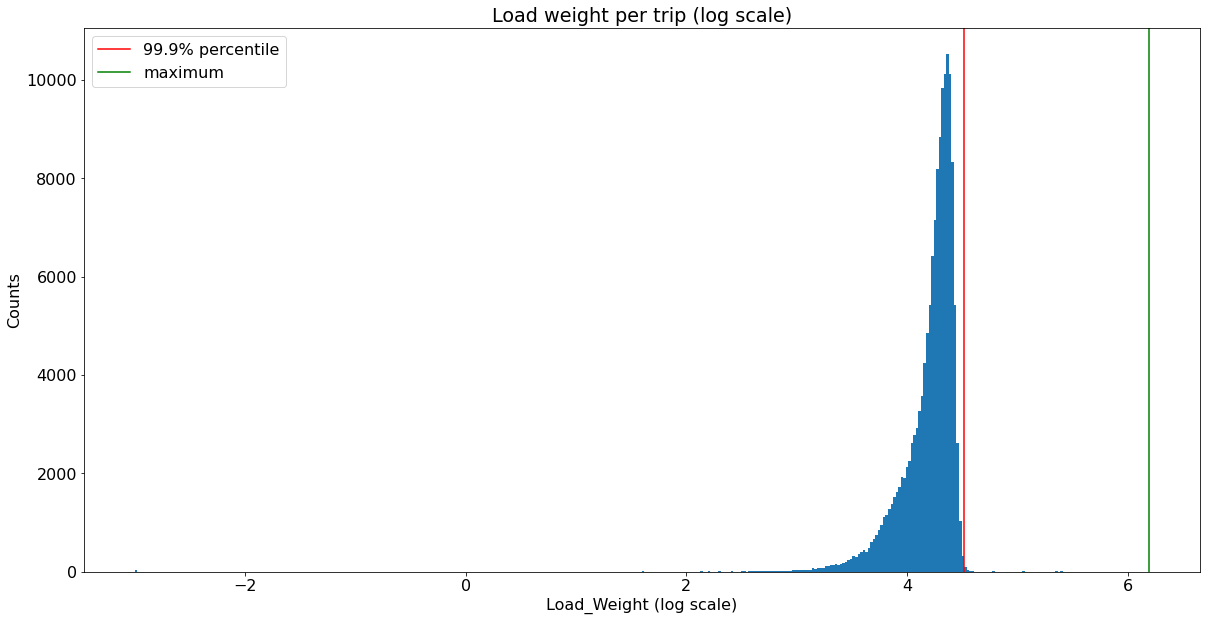

Total before thresholding: 145871
Total after thresholding: 145705


In [6]:
assumptions_data = reader.filter_assumptions(data)
garbage_collection = assumptions_data["Load Weight"] 
threshold_max = garbage_collection.quantile(q=0.999)
# Substitute nan s with zeros
garbage_collection_clean = np.nan_to_num(garbage_collection.to_numpy())
epsilon = 1e-3
garbage_collection_clean = np.log10(garbage_collection_clean+epsilon)
plt.figure(figsize=(20,10))
plt.title("Load weight per trip (log scale)")
plt.hist(garbage_collection_clean, bins = 400)
plt.axvline(np.log10(threshold_max), c='r')
plt.axvline(np.log10(garbage_collection.max()), c='g')
plt.legend(["99.9% percentile", "maximum"])
plt.ylabel("Counts")
plt.xlabel("Load_Weight (log scale)")
plt.show()
print(f"Total before thresholding: {garbage_collection.shape[0]}")
garbage_collection_clean = garbage_collection[garbage_collection < threshold_max]
print(f"Total after thresholding: {garbage_collection_clean.shape[0]}")
garbage_collection_clean = np.nan_to_num(garbage_collection_clean.to_numpy()) / threshold_max


# Global garbage collection daily route efficiency

Text(0.5, 0, 'Day of the year')

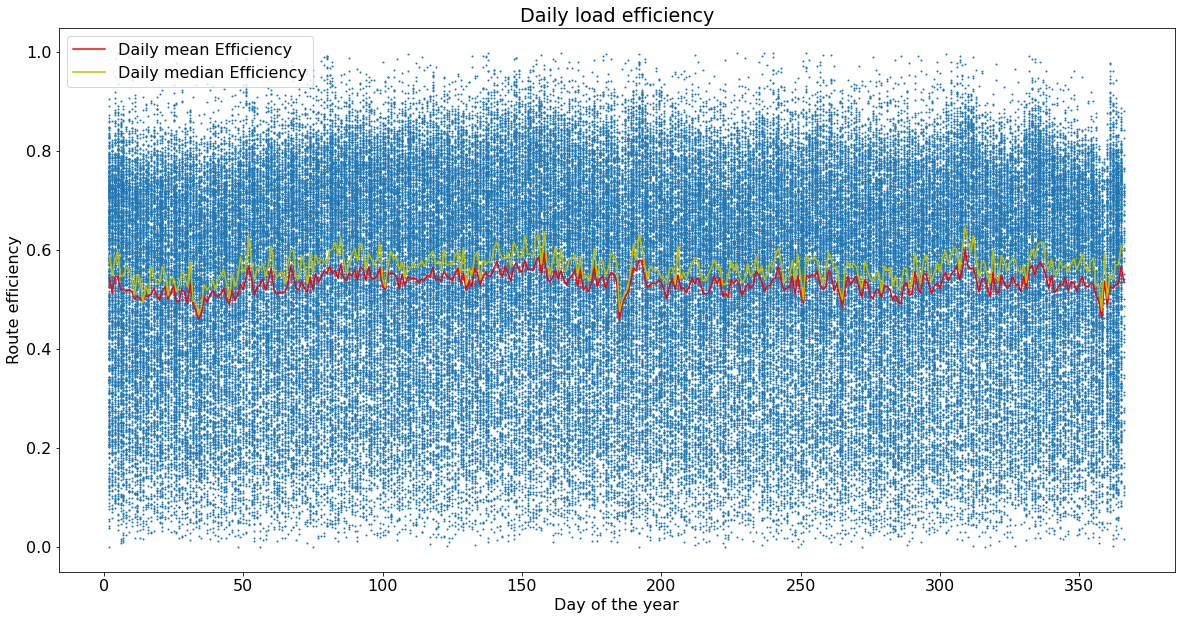

In [7]:
[fig,ax] = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
 
clean_ordered_garbage_collection = assumptions_data[assumptions_data["Load Weight"] < threshold_max]
clean_ordered_garbage_collection['efficiency'] = clean_ordered_garbage_collection["Load Weight"] / threshold_max
ax.scatter(clean_ordered_garbage_collection['Report Date'].dt.dayofyear, clean_ordered_garbage_collection['efficiency'], s = 1)
daily_summary = clean_ordered_garbage_collection.groupby(clean_ordered_garbage_collection['Report Date'].dt.dayofyear).agg({'efficiency':[np.mean,np.median]})
daily_summary.columns = ['mean','median']
daily_summary.reset_index(inplace=True)
ax.plot(daily_summary['Report Date'], daily_summary['mean'],'r',label='Daily mean Efficiency')
ax.plot(daily_summary['Report Date'], daily_summary['median'],'y',label='Daily median Efficiency')
ax.legend()
ax.set_title('Daily load efficiency')
ax.set_ylabel('Route efficiency')
ax.set_xlabel('Day of the year')



# WeightPredictor class

### Here we present an object that can control the sending of trucks based on a predictive model of the expected trash generated and optimizing for the truck efficiency - defined as the percentage of the full cargo that a truck. carries

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
#from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge

class WeightPredictor():
    
    def __init__(self, route='all', load_type = 'GARBAGE COLLECTIONS'):
        """
        These are the variables that will decide on which data we are training on
        """
        self.route = route
        self.load_type = load_type
        self.cummulative_trash = 0
        self.threshold_max = None
    
    
    def data_processing(self, data, weather, train=True):
        """
        This function receive the raw waste input + weather reports and creates an input/output
        pair that can be fed into the models directly for training.
        """
        # filter by load type
        garbage_collection = data[data["Load Type"] == self.load_type]
        # define max load weight
        if self.threshold_max is None:
            self.threshold_max = garbage_collection["Load Weight"].quantile(q=0.999)
        # filter by report date: after global crisis until covid
        ordered_garbage_collection = garbage_collection.sort_values("Report Date")
        ordered_garbage_collection = ordered_garbage_collection[garbage_collection["Report Date"].dt.year > 2010]
        ordered_garbage_collection = ordered_garbage_collection[garbage_collection["Report Date"].dt.year < 2019]
        # filter by route
        if self.route != 'all':
            ordered_garbage_collection = ordered_garbage_collection[ \
                                                ordered_garbage_collection["Route Number"] == self.route]

        # remove load weight outliers
        clean_ordered_garbage_collection = \
            ordered_garbage_collection[garbage_collection["Load Weight"] < self.threshold_max]
        ### extract features:
        #   from date
        day = clean_ordered_garbage_collection["Report Date"].dt.day.to_numpy()
        year = clean_ordered_garbage_collection["Report Date"].dt.year.to_numpy()
        month = clean_ordered_garbage_collection["Report Date"].dt.month.to_numpy()
        weekday = clean_ordered_garbage_collection["Report Date"].dt.day.to_numpy()
        #   from time interval between two consecutive route trips
        time_delta = [0] # first value
        for i in range(clean_ordered_garbage_collection.shape[0]-1):
            time_tmp = clean_ordered_garbage_collection["Report Date"].iloc[i+1] - \
                clean_ordered_garbage_collection["Report Date"].iloc[i]
            time_delta.append(time_tmp.seconds)
        time_delta = np.array(time_delta)
        #   from weather report
        weather['date'] = pd.to_datetime(weather['date'],format= '%Y-%m-%d')
        clean_ordered_garbage_collection = clean_ordered_garbage_collection \
            .merge(weather,left_on='Report Date',right_on='date', how='left')
        clean_ordered_garbage_collection = clean_ordered_garbage_collection \
            .drop(["date","snow", "tsun","wpgt", "wdir"], axis=1)
        
        # Concatenate features
        X = np.vstack([day, month, year, weekday, time_delta, \
            clean_ordered_garbage_collection[['tavg','tmin','tmax','prcp','wspd','pres']].to_numpy().T]).T
        X = np.nan_to_num(X.astype(float))
        y= np.nan_to_num(clean_ordered_garbage_collection["Load Weight"].to_numpy())
        
        if train == False:
            return X, y
        # remove last year for model testing purposes
        X_train, X_test, y_train, y_test = X[np.where(X[:,2] != 2018)], X[np.where(X[:,2] == 2018)], \
                                            y[np.where(X[:,2] != 2018)], y[np.where(X[:,2] == 2018)]
        
        indices = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[indices], y_train[indices]
        
        self.transformer = MinMaxScaler().fit(y_train[:, np.newaxis])
        self.transformer_input = MinMaxScaler().fit(X_train)

        X_train = self.transformer_input.transform(X_train)
        X_test = self.transformer_input.transform(X_test)

        y_train = self.transformer.transform(y_train[:, np.newaxis]).flatten()
        y_test = self.transformer.transform(y_test[:, np.newaxis]).flatten()
        
        return X_train, X_test, y_train, y_test
    
    
    def predict(self, data, model):
        """
        Predicts the given data with the given model.
        Applies the inverse transformation to the data (scaling)
        """
        y_hat_scaled = model.predict(data)
        if len(y_hat_scaled.shape)==1:
            y_hat_scaled =y_hat_scaled[:, np.newaxis]
        y_hat = self.transformer.inverse_transform(y_hat_scaled)
        return y_hat
    
    
    def train_models(self, X_train, y_train, X_test, y_test):
        """
        Trains several pre-set models and outputs its 
        RMSE performance
        """
        self.model_lr = LinearRegression()
        self.model_lr.fit(X_train, y_train)
        y_hat = self.model_lr.predict(X_test)
        rmse = np.sqrt(np.mean((y_test-y_hat)**2))
        print(f"Linear Regression RMSE: {rmse}")
        ############################################
        self.model_sgd = SGDRegressor()
        self.model_sgd.fit(X_train, y_train)
        y_hat = self.model_sgd.predict(X_test)
        rmse = np.mean(np.sqrt((y_test-y_hat))**2)
        print(f"SGDRegressor Regression RMSE: {rmse}")
        ############################################
        self.model_e = ElasticNet()
        self.model_e.fit(X_train, y_train)
        y_hat = self.model_e.predict(X_test)
        rmse = np.sqrt(np.mean((y_test-y_hat)**2))
        print(f"Elastic Net RMSE: {rmse}")
        ############################################
        self.model_gbr = GradientBoostingRegressor()
        self.model_gbr.fit(X_train, y_train)
        y_hat = self.model_gbr.predict(X_test)
        rmse = np.sqrt(np.mean((y_test-y_hat)**2))
        print(f"Gradient Boosting RMSE: {rmse}")
        ############################################
        self.model_br = BayesianRidge()
        self.model_br.fit(X_train, y_train)
        y_hat = self.model_br.predict(X_test)
        rmse = np.sqrt(np.mean((y_test-y_hat)**2))
        print(f"BayesRidge RMSE: {rmse}")
        ############################################
        
        
    def train_other_model(self, X_train, y_train, X_test, y_test, model):
        """
        Function that allows that any model with fit and predict functions are used to train
        the given data.
        """
        self.model = model
        self.model.fit(X_train, y_train)
        y_hat = self.model.predict(X_test)
        rmse = np.sqrt(np.mean((y_test-y_hat)**2))
        print(f"Defined model's RMSE: {rmse}")
        
        
    def send_truck(self, leeway, x, model):
        """
        Live analysis and prediction of the waste weight for truck control and 
        defining when to launch truck to a given route
        """
        self.cummulative_trash += np.sum(self.predict(x, model))
        if self.cummulative_trash >= self.threshold_max - (self.threshold_max * leeway):
            print(f"Send a truck to collect the trash on Route {self.route}")
            self.cummulative_trash = 0
            return True
        else:
            print(f"No action required on Route {self.route}")
            return False
        
    

In [9]:
# Instantiate class with specific route
route_id = 'PAM52'
wp = WeightPredictor(route=route_id)

In [10]:
# Load data
data = DataReader().load_data('./data/Waste_Collection___Diversion_Report__daily_.csv')
weather = pd.read_csv('data/Weather_data_Austin.csv')
no_opt_data_points = 500
data.sort_values(by='Report Date')
data_model = data[:-no_opt_data_points]

In [11]:
# Split dataset for modeling
X_train, X_test, y_train, y_test = wp.data_processing(data_model, weather, train=True)

In [12]:
# Train our models
wp.train_models(X_train, y_train, X_test, y_test)

Linear Regression RMSE: 0.24240094602881113
SGDRegressor Regression RMSE: nan
Elastic Net RMSE: 0.2454975252887525
Gradient Boosting RMSE: 0.2718218076527228
BayesRidge RMSE: 0.24551324084151382


In [13]:
# Reprocess the data
x, y = wp.data_processing(data, weather, train=False)

# How much efficiency are we gaining vs the baseline?

Let's simulate us sending the trucks based on our savvy predictive model!
How much efficiency are we gaining in each truck we send?

In [14]:
real_cummulative = 0
truck_weight =[]
track_idx = []
n_trips = len(x)
leeway = 0.24 # leeway is the rmse from the used model
for i in reversed(range(n_trips)):
    print(f"Live track:  {int(x[-i,0])}/{int(x[-i,1])}/{int(x[-i,2])}")
    real_cummulative+= y[-i]
    flag = wp.send_truck(leeway=leeway, x=x[-i,:][np.newaxis,:], model=wp.model_gbr)  
    if flag:
        truck_weight.append(real_cummulative)
        real_cummulative = 0
        track_idx.append(i)
    print("=============================")

Live track:  28/7/2014
No action required on Route PAM52
Live track:  28/7/2014
Send a truck to collect the trash on Route PAM52
Live track:  4/8/2014
No action required on Route PAM52
Live track:  11/8/2014
Send a truck to collect the trash on Route PAM52
Live track:  11/8/2014
No action required on Route PAM52
Live track:  18/8/2014
Send a truck to collect the trash on Route PAM52
Live track:  25/8/2014
No action required on Route PAM52
Live track:  25/8/2014
Send a truck to collect the trash on Route PAM52
Live track:  1/9/2014
No action required on Route PAM52
Live track:  8/9/2014
Send a truck to collect the trash on Route PAM52
Live track:  15/9/2014
No action required on Route PAM52
Live track:  22/9/2014
Send a truck to collect the trash on Route PAM52
Live track:  22/9/2014
No action required on Route PAM52
Live track:  29/9/2014
Send a truck to collect the trash on Route PAM52
Live track:  6/10/2014
No action required on Route PAM52
Live track:  6/10/2014
Send a truck to coll

## How many truck trips are we saving?

Out of 312 we are saving 139 trips!!
Mean optimized efficiency is 0.84, while the original was 0.63!!


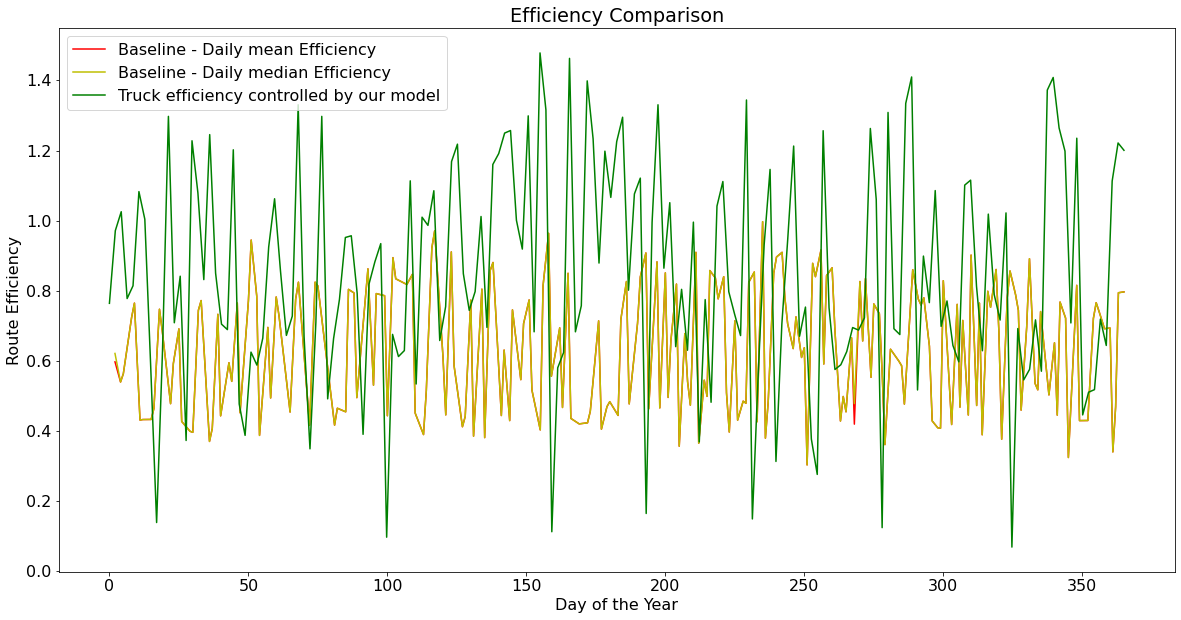

In [15]:
our_efficiency_ratio = np.array(truck_weight) / (wp.threshold_max+leeway*wp.threshold_max)

[fig,ax] = plt.subplots(nrows=1,ncols=1,figsize=(20,10))
garbage_collection = data[ \
    (data['Route Number'] == 'PAM52') &  \
    (data['Report Date'].dt.year > 2010) &  \
    (data['Report Date'].dt.year < 2019)]
# Average performance of truck ratio 
clean_ordered_garbage_collection = garbage_collection[garbage_collection["Load Weight"] < wp.threshold_max]
clean_ordered_garbage_collection['efficiency'] = clean_ordered_garbage_collection["Load Weight"] / wp.threshold_max
daily_summary = clean_ordered_garbage_collection.groupby(clean_ordered_garbage_collection['Report Date'].dt.dayofyear).agg({'efficiency':[np.mean,np.median]})
daily_summary.columns = ['mean','median']
daily_summary.reset_index(inplace=True)

ax.plot(daily_summary['Report Date'], daily_summary['mean'],'r',label='Baseline - Daily mean Efficiency')
ax.plot(daily_summary['Report Date'], daily_summary['median'],'y',label='Baseline - Daily median Efficiency')


# Our results with the efficiency controlled by the WeightPredictor()
ax.plot(np.linspace(0, 365, len(our_efficiency_ratio)), our_efficiency_ratio,'g',label='Truck efficiency controlled by our model')
ax.legend()
ax.set_title('Efficiency Comparison')

plt.ylabel('Route Efficiency')
plt.xlabel('Day of the Year')


our_model_n_trips = len(truck_weight)
print(f"Out of {n_trips} we are saving {n_trips - our_model_n_trips} trips!!")

print(f"Mean optimized efficiency is {our_efficiency_ratio.mean():.2f}, while the original was {daily_summary['mean'].mean():.2f}!!")

### Out of 312 we are saving 139 trips!!

### Mean optimized efficiency is 0.84, while the original was 0.63!!